# STORM - LangChain

<img src="storm.png"></img>

STORM is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

Creating an outline (planning) by querying similar topics helps improve coverage.
Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density.
The control flow looks like the diagram below.

STORM has a few main stages:

Generate initial outline + Survey related subjects
Identify distinct perspectives
"Interview subject matter experts" (role-playing LLMs)
Refine outline (using references)
Write sections, then write article
The expert interviews stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

There are a couple hyperparameters you can set to restrict the (potentially) infinite research breadth:

N: Number of perspectives to survey / use (Steps 2->3) M: Max number of conversation turns in step (Step 3)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core

In [2]:
from dotenv import load_dotenv

_ = load_dotenv("src/local.env")

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [5]:
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst."
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the contex of the topic."
    )
    description: str = Field(
        description="Description of the analyst focus, and motives."
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [6]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations."
    )

In [7]:
class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

In [8]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

In [9]:
analyst_instructions = """
You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [43]:
def create_analysts(state: GenerateAnalystsState):
    
    """ 
    Create analysts 
    """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )
    
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    return {"analysts": analysts.analysts}

In [35]:
def human_feedback(state: GenerateAnalystsState):
    """ 
    No-op node that should be interrupted on
    """
    pass

In [36]:
def should_continue(state: GenerateAnalystsState):
    """
    Return the next node to execute
    """

    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    return END

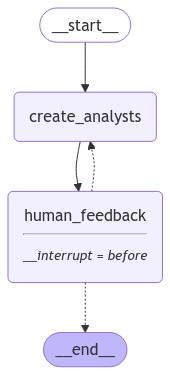

In [37]:
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [39]:
max_analysts = 3
topic = "how to create ec2 instance"
thread = {"configurable": {"thread_id": "1"}}

graph.invoke({"topic": topic, "max_analysts": max_analysts, "human_analyst_feedback": ""}, thread)

user_approval = input("Are you satisfied with generated analysts (yes/no): ")

if user_approval.lower() == "yes":
    result = graph.invoke(None, thread)  
else:
    user_feedback = input("How would you improve analyst creation: ")
    graph.invoke({"topic": topic + "," + user_feedback, "max_analysts": max_analysts, "human_analyst_feedback": ""}, thread)
    result = graph.invoke(None, thread)

Are you satisfied with generated analysts (yes/no):  yes


In [40]:
print(result)

{'topic': 'how to create ec2 instance', 'max_analysts': 3, 'human_analyst_feedback': '', 'analysts': [Analyst(affiliation='Amazon Web Services', name='Alice Johnson', role='Cloud Solutions Architect', description='Alice specializes in cloud infrastructure and has extensive experience in deploying and managing EC2 instances. She focuses on best practices for scalability and cost optimization.'), Analyst(affiliation='Tech Innovations Inc.', name='Bob Smith', role='DevOps Engineer', description='Bob is a DevOps engineer with a passion for automation and continuous integration. He explores how to streamline the process of creating and managing EC2 instances using Infrastructure as Code.'), Analyst(affiliation='Cloud Security Group', name='Catherine Lee', role='Cloud Security Analyst', description='Catherine is a cloud security expert who emphasizes the importance of security when creating EC2 instances. She focuses on compliance, risk management, and securing cloud environments.')]}


In [41]:
state = graph.get_state(thread)
state.next

()

In [42]:
for analyst in result["analysts"]:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)  

Name: Alice Johnson
Affiliation: Amazon Web Services
Role: Cloud Solutions Architect
Description: Alice specializes in cloud infrastructure and has extensive experience in deploying and managing EC2 instances. She focuses on best practices for scalability and cost optimization.
--------------------------------------------------
Name: Bob Smith
Affiliation: Tech Innovations Inc.
Role: DevOps Engineer
Description: Bob is a DevOps engineer with a passion for automation and continuous integration. He explores how to streamline the process of creating and managing EC2 instances using Infrastructure as Code.
--------------------------------------------------
Name: Catherine Lee
Affiliation: Cloud Security Group
Role: Cloud Security Analyst
Description: Catherine is a cloud security expert who emphasizes the importance of security when creating EC2 instances. She focuses on compliance, risk management, and securing cloud environments.
--------------------------------------------------


## Conduct Interview

### Generate Question
The analyst will ask questions to the expert.

In [18]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

In [19]:
class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: str

In [20]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval")

In [21]:
question_instructions = """
You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [22]:
def generate_question(state: InterviewState):
    """
    Node to generate a question
    """

    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    return {"messages": [question]}

### Generate Answer: Parallelization
The expert will gather information from multiple sources in parallel to answer questions.

In [23]:
from langchain_core.messages import get_buffer_string

from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

from langchain_community.document_loaders import WikipediaLoader

In [24]:
search_instructions = SystemMessage(
    content="""
    You will be given a conversation between an analyst and an expert.

    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

    First, analyze the full conversation.

    Pay particular attention to the final question posed by the analyst.

    Convert this final question into a well-structred web search query""")

In [25]:
def search_web(state: InterviewState):
    
    """ 
    Retrieve docs from web search
    """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [26]:
def search_wikipedia(state: InterviewState):
    
    """ 
    Retrieve docs from wikipedia
    """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [27]:
answer_instructions = """
You are an expert being interview by an analyst.

Here is analyst area of focus: {goals}.

Your goal is to answer a question posed by the interviewer.

To answer question, use this context:
{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [28]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """

    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(system_message)] + messages)

    answer.name = "expert"
    
    return {"messages": [answer]}

In [29]:
def save_interview(state: InterviewState):
    """
    Save interviews
    """

    messages = state["messages"]
    interview = get_buffer_string(messages)

    return {"interview": interview}

In [44]:
def route_messages(state: InterviewState, name: str = "expert"):
    """
    Route between question and answer
    """

    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses >= max_num_turns:
        return "save_interview"

    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

In [45]:
section_writer_instructions = """
You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [46]:
def write_section(state: InterviewState):

    """ 
    Node to answer a question 
    """
    
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    return {"sections": [section.content]}

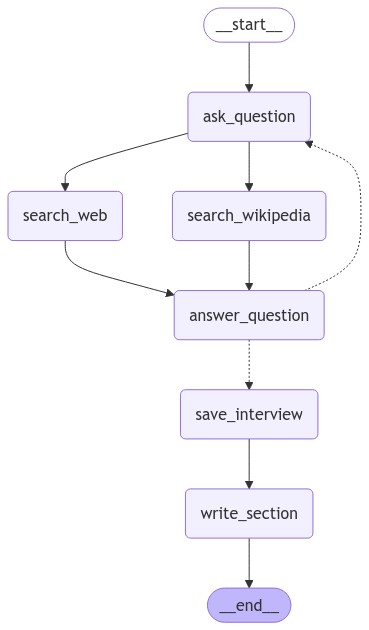

In [47]:
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [49]:
analysts = result["analysts"]
analysts[0]

Analyst(affiliation='Amazon Web Services', name='Alice Johnson', role='Cloud Solutions Architect', description='Alice specializes in cloud infrastructure and has extensive experience in deploying and managing EC2 instances. She focuses on best practices for scalability and cost optimization.')

In [52]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Maximizing Efficiency: Best Practices for EC2 Cost Optimization

### Summary
In the realm of cloud infrastructure, particularly with Amazon EC2, cost optimization is a critical focus for organizations aiming to balance performance and expenditure. As businesses increasingly migrate to the cloud, understanding how to effectively manage costs while ensuring scalability becomes paramount. This report synthesizes insights from various sources on best practices for optimizing EC2 costs, revealing novel strategies that can lead to significant savings without compromising performance.

One of the most surprising insights is the effectiveness of **auto-scaling**. This technique allows organizations to automatically adjust the capacity of their EC2 instances based on real-time workload demands. By scaling down during periods of low demand, businesses can avoid unnecessary costs associated with idle resources, thus enhancing fault tolerance at minimal expense [1][4]. 

Another fundamental principle is **rightsizing**. This involves selecting instance types that closely match workload requirements, thereby preventing overprovisioning. For instance, a web application hosted on EC2 can benefit from careful analysis to ensure that the chosen instance types are not only sufficient but also cost-effective [2]. 

Moreover, monitoring less utilized EC2 instances is crucial. By evaluating resource usage, organizations can identify underperforming instances and either terminate or resize them, leading to substantial savings [3]. The use of reserved and spot instances is also highlighted as a strategic approach to further reduce costs while maintaining necessary performance levels [2][3].

In summary, the combination of auto-scaling, rightsizing, and diligent monitoring of resource utilization forms a robust framework for EC2 cost optimization. These practices not only help in managing expenses but also ensure that businesses can scale their operations efficiently in response to changing demands.

### Sources
[1] https://blog.economize.cloud/ec2-cost-optimization/  
[2] https://community.aws/content/2hQNGTh6vpwOHTgKELzL8mkqmKb/ec2-cost-optimization-15-ways-to-save-on-amazon-ec2  
[3] https://www.lucidity.cloud/blog/aws-ec2-cost-optimization  
[4] https://www.prosperops.com/blog/aws-auto-scaling  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [53]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

In [54]:
class ResearchGraphState(TypedDict):
    topic: str 
    max_analysts: int 
    human_analyst_feedback: str 
    analysts: List[Analyst] 
    sections: Annotated[list, operator.add]
    introduction: str 
    content: str 
    conclusion: str
    final_report: str

In [55]:
from langgraph.constants import Send

In [56]:
def initiate_all_interviews(state: ResearchGraphState):
    """
    This is the "map" step where we run each interview sub-graph using Send API
    """

    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

   
    else:
        topic = state["topic"]
        return [Send("conduct_interview", 
                     {"analyst": analyst,
                      "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
                     }) for analyst in state["analysts"]]

In [57]:
report_writer_instructions = """
You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [58]:
def write_report(state: ResearchGraphState):
    
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    
    return {"content": report.content}

In [59]:
intro_conclusion_instructions = """
You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [60]:
def write_introduction(state: ResearchGraphState):

    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    
    return {"introduction": intro.content}

In [61]:
def write_conclusion(state: ResearchGraphState):

    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    
    return {"conclusion": conclusion.content}

In [62]:
def finalize_report(state: ResearchGraphState):
    """ 
    The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion 
    """
    
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
        
    return {"final_report": final_report}

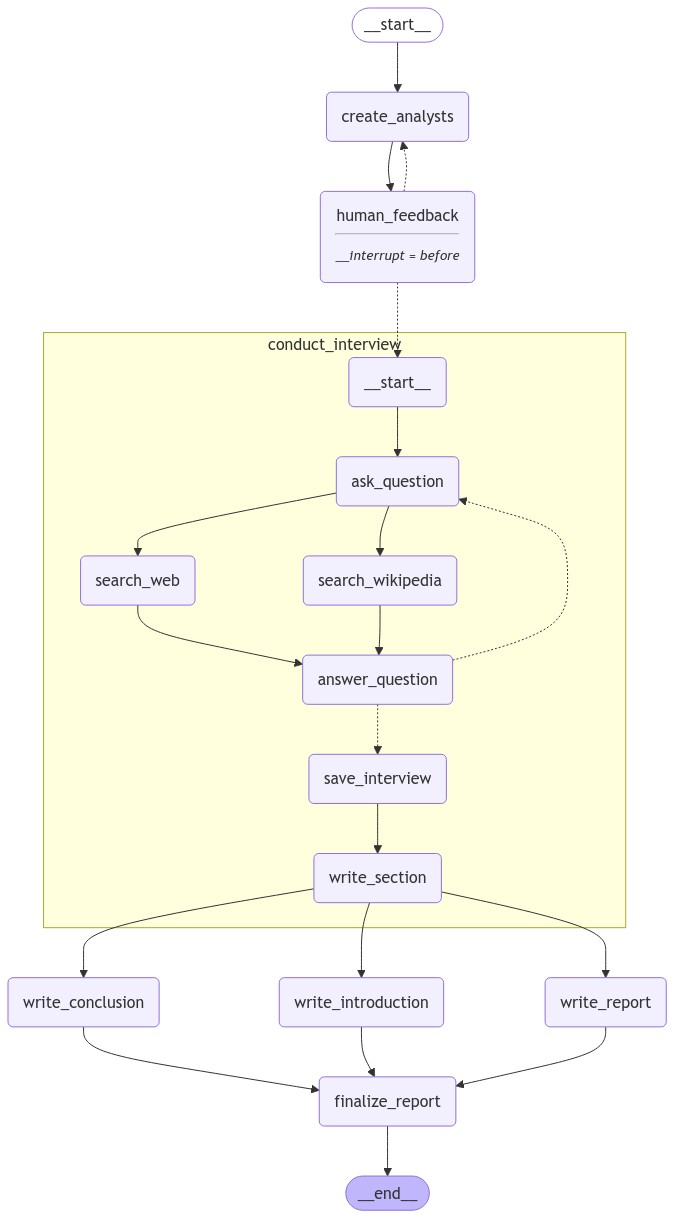

In [63]:
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [64]:
max_analysts = 3
topic = "how to create ec2 instance"
thread = {"configurable": {"thread_id": "1"}}

graph.invoke({"topic": topic, "max_analysts": max_analysts, "human_analyst_feedback": ""}, thread)

user_approval = input("Are you satisfied with generated analysts (yes/no): ")

if user_approval.lower() == "yes":
    result = graph.invoke(None, thread)  
else:
    user_feedback = input("How would you improve analyst creation: ")
    graph.invoke({"topic": topic + "," + user_feedback, "max_analysts": max_analysts, "human_analyst_feedback": ""}, thread)
    result = graph.invoke(None, thread)

Are you satisfied with generated analysts (yes/no):  no
How would you improve analyst creation:  Add in the CEO of gen ai native startup


In [65]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Transforming Cloud Management: The Role of AI in EC2 Optimization

## Introduction

As businesses increasingly rely on cloud computing, the integration of artificial intelligence (AI) into Amazon Web Services (AWS) is reshaping the management of Amazon Elastic Compute Cloud (EC2) instances. This report explores innovative cloud solutions that leverage AI for optimized EC2 management, highlighting advancements such as the unique DL1 instance type and Amazon Elastic Inference, which significantly reduce operational costs. We also address common challenges in EC2 management and present best practices for overcoming them. By examining the intersection of AI and cloud computing, this report underscores the potential for enhanced efficiency and cost-effectiveness in managing EC2 instances, ultimately driving business growth and technological advancement.

---


The integration of artificial intelligence (AI) with Amazon Web Services (AWS) is significantly transforming the management and deployment of Amazon Elastic Compute Cloud (EC2) instances. Recent advancements in AI technologies are streamlining processes, enhancing performance, and reducing operational costs, making cloud infrastructure more efficient and cost-effective.

One of the key innovations is the introduction of specialized EC2 instance types, such as the DL1 instances utilizing Habana Gaudi chips for deep learning, and the M7i instances powered by 4th Gen Intel® Xeon® Scalable processors, which can reduce inference costs by up to 2.5 times compared to previous models [1]. Additionally, the EC2 DL2q instances, equipped with Qualcomm AI 100 Standard accelerators, facilitate cost-efficient deployment of deep learning workloads, ensuring performance and accuracy during transitions to Qualcomm devices [2]. The collaboration between AWS and NVIDIA has also led to the development of EC2 P5 instances, optimized for training large machine learning models, which can improve training times by up to four times [3].

AI-driven automation tools are emerging as essential components in infrastructure management. These tools can automate the provisioning of EC2 instances, RDS databases, and S3 buckets, leading to more efficient resource management and cost optimization [4]. Intelligent automation can also manage power cycles of development instances, ensuring resources are utilized only when necessary [5]. Furthermore, integrating AI with infrastructure management tools like Terraform enhances data-driven decision-making regarding instance utilization, such as recommending downsizing underutilized instances [6].

However, managing EC2 instances is not without challenges. Common issues include failures to launch instances due to misconfigurations or resource limitations, and the importance of selecting the appropriate Amazon Machine Image (AMI) for instance connectivity [1]. Users must also be cautious of Free Tier usage limits to avoid unexpected charges [2]. Best practices for managing EC2 instances include right-sizing based on workload characteristics, utilizing Spot Instances for cost savings, and continuously monitoring performance [3][4]. Understanding the different EC2 instance families—General Purpose, Compute-Optimized, and Memory-Optimized—can help users make informed decisions tailored to their specific application needs [5].

In summary, the intersection of AI and cloud computing is paving the way for more efficient, cost-effective, and innovative solutions in managing EC2 instances. As organizations continue to explore these advancements, the ability to deploy flexible and specialized resources will be crucial for optimizing cloud expenditures and enhancing operational performance.


---

## Conclusion

In conclusion, the integration of artificial intelligence with Amazon EC2 is reshaping cloud infrastructure management, offering innovative solutions that enhance efficiency and reduce costs. This report has explored the transformative impact of AI on EC2 instance management, highlighting advancements such as the DL1 instance type and Amazon Elastic Inference, which significantly lower operational expenses. We also examined common challenges users face with EC2 and best practices for optimizing performance and cost. As organizations increasingly adopt AI-driven automation tools and specialized instance types, they can expect improved resource management and accelerated innovation, positioning themselves for success in a competitive landscape.

## Sources
[1] https://www.intel.com/content/www/us/en/developer/articles/technical/accelerate-your-ai-software-workloads-on-aws.html  
[2] https://aws.amazon.com/blogs/machine-learning/optimizing-costs-for-machine-learning-with-amazon-sagemaker/  
[3] https://aws.amazon.com/ec2/instance-types/inf1/  
[4] https://www.linkedin.com/pulse/aws-infrastructure-automation-services-using-ai-tools-lcsuc/  
[5] https://nuvento.com/blog/leveraging-ai-for-efficient-cloud-management/  
[6] https://medium.com/@shane.digital.ai/automating-aws-provisioning-with-terraform-using-claude-ai-powered-provisioning-7b72a5a56ade  
[7] https://aws.plainenglish.io/what-are-the-common-issues-in-aws-ec2-instances-20adce409a7c  
[8] https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EC2_GetStarted.html  
[9] https://hands-on.cloud/amazon-ec2-instance-types/  
[10] https://aws.amazon.com/blogs/aws/choosing-the-right-ec2-instance-type-for-your-application/  
[11] https://medium.com/@bilal325/comparing-ec2-instance-types-finding-the-right-fit-for-your-workload-701d454031f  
[12] https://community.intel.com/t5/Blogs/Tech-Innovation/Cloud/Flexible-and-cost-effective-LLM-deployment-with-Amazon-EC2-M7i/post/1590028  
[13] https://aws.amazon.com/blogs/machine-learning/amazon-ec2-dl2q-instance-for-cost-efficient-high-performance-ai-inference-is-now-generally-available/  
[14] https://press.aboutamazon.com/2023/3/aws-and-nvidia-collaborate-on-next-generation-infrastructure-for-training-large-machine-learning-models-and-building-generative-ai-applications  
[15] https://en.wikipedia.org/wiki/Amazon_Elastic_Compute_Cloud  
[16] https://opsiocloud.com/resource/blog/ec2-cost-optimization-maximizing-aws-efficiency/  
[17] https://www.toptal.com/aws/aws-cost-optimization-at-scale